In [1]:
%matplotlib inline

import numpy as np
import pydicom as dicom
import os
import matplotlib.pyplot as plt
import scipy.ndimage
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure

In [2]:
def load_scan(path):
    slices=[dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x:int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != -1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    return np.array(image, dtype=np.int16)

def sample_stack(stack, rows=5, cols=5, start_with=0, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[15,15])
    for i in range(rows*cols):
        index = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice {}'.format(index+1))
        x=stack[index].squeeze()
        ax[int(i/rows),int(i % rows)].imshow(x,cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

def resample(image, scan, new_spacing=[1,1,1]):
    x = [patient[0].SliceThickness]
    x.extend(patient[0].PixelSpacing)
    spacing = map(float, x)
    spacing = np.array(list(spacing))
    
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    return image

def make_lungmask(img):
    row_size = img.shape[0]
    col_size = img.shape[1]
    mean = np.mean(img)
    std = np.std(img)
    max = np.max(img)
    min = np.min(img)
    
    img = img - mean
    img = img / std
    
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)]
    mean = np.mean(middle)
    img[img==max]=mean
    img[img==min]=mean
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)
    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))
    
    labels = measure.label(dilation)
    label_vlas = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
            
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10]))
    
    return mask*img

In [3]:
data_path = './data/CT-Training-LC003/1.2.840.113704.1.111.5804.1168615966.1/1.2.840.113704.1.111.5804.1168617251.15/'
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)
imgs_after_resampling = resample(imgs,patient)

In [4]:
masked_lung = []

for img in imgs_after_resampling:
    masked_lung.append(make_lungmask(img))

Before Mask:


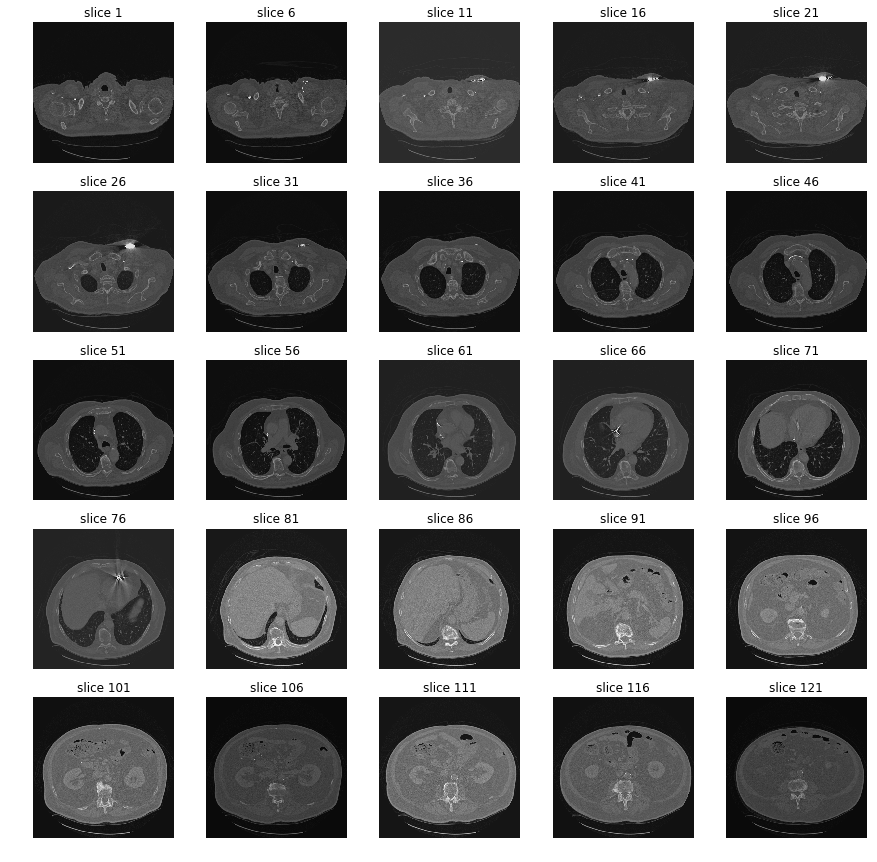

After Mask:


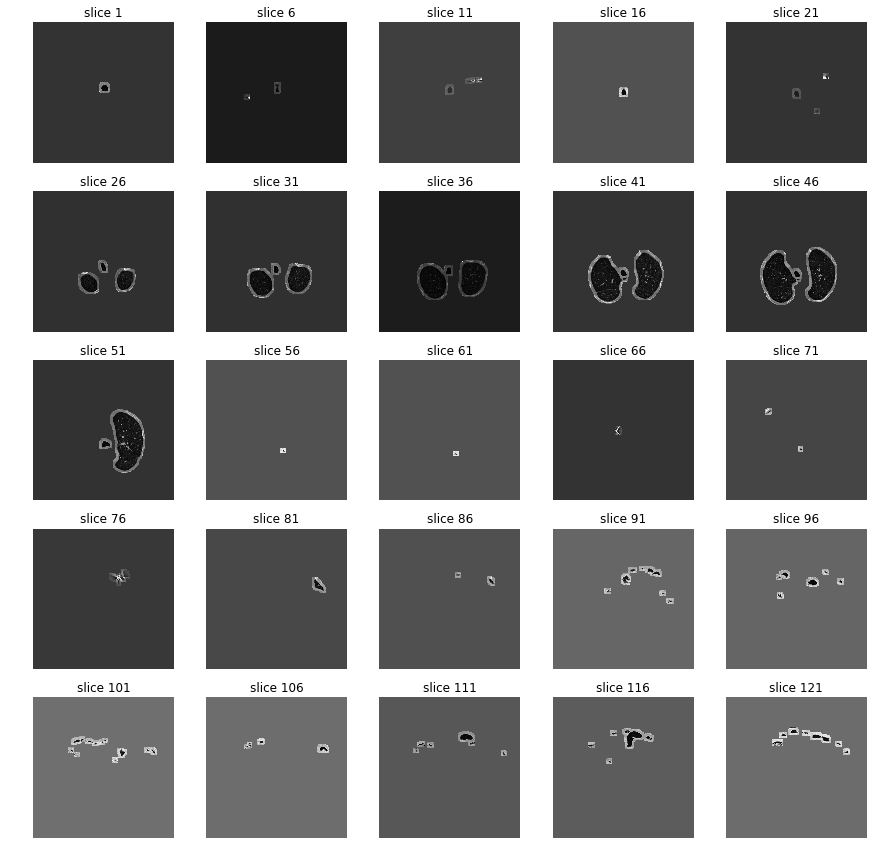

In [6]:
print("Before Mask:")
sample_stack(imgs_after_resampling,show_every=5)
print("After Mask:")
sample_stack(masked_lung,show_every=5)

In [7]:
np.save('./processed data/'+"fullimages_2.npy",imgs)